# 5) IFU line fitting

In this tutorial, we are going to fit the lines using the spaxels from the masks we created in the [previous tutorial](https://lime-stable.readthedocs.io/en/latest/tutorials/n_tutorial4_IFU_masking.html).
You can download this tutorial as a [python script](https://github.com/Vital-Fernandez/lime/blob/master/examples/example5_IFU_fitting.py) and a [jupyter notebook](https://github.com/Vital-Fernandez/lime/blob/master/examples/notebook5_IFU_Line_Fitting.ipynb).


This tutorial can found as a script and a notebook on the [examples folder](https://github.com/Vital-Fernandez/lime/tree/master/examples/tutorials). The observation itself, you will need to download it from the [MANGA survey](https://www.sdss4.org/surveys/manga/). The galaxy we shall study is [SHOC579](https://dr17.sdss.org/marvin/galaxy/8626-12704/), a compact galaxy with an intense star forming region.

## Loading the data

Let’s start by importing the libraries we need:

In [1]:
from pathlib import Path
from astropy.io import fits
from astropy.wcs import WCS
from IPython.display import Image, display
import lime

and declare the inputs/outputs paths

In [2]:
# State the data location
cfg_file = Path('../sample_data/manga.toml')
cube_file = Path('../sample_data/spectra/manga-8626-12704-LOGCUBE.fits.gz')
bands_file_0 = Path('../sample_data/SHOC579_MASK0_bands.txt')
spatial_mask_file = Path('../sample_data/SHOC579_mask.fits')
output_lines_log_file = Path('../sample_data/SHOC579_log.fits')

Now, we load the configuration file.

In [3]:
# Load the configuration file:
obs_cfg = lime.load_cfg(cfg_file)

# Observation properties
z_obj = obs_cfg['SHOC579']['redshift']

In the [previous tutorial](https://lime-stable.readthedocs.io/en/latest/tutorials/n_tutorial4_IFU_masking.html), we opened the *.fits* file using astropy functions to extract the wavelength and flux arrays, as well as, the [WCS](https://fits.gsfc.nasa.gov/fits_wcs.html). In this ocasion, we are going to use the ``lime.cube.from_file`` function to directly read the file into a ``lime.Cube``. In this case we only need to provide the observation redshift:

a string value was expected. [astropy.wcs.wcs]
/home/vital/PycharmProjects/lime/.venv/new_interpr/lib/python3.10/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


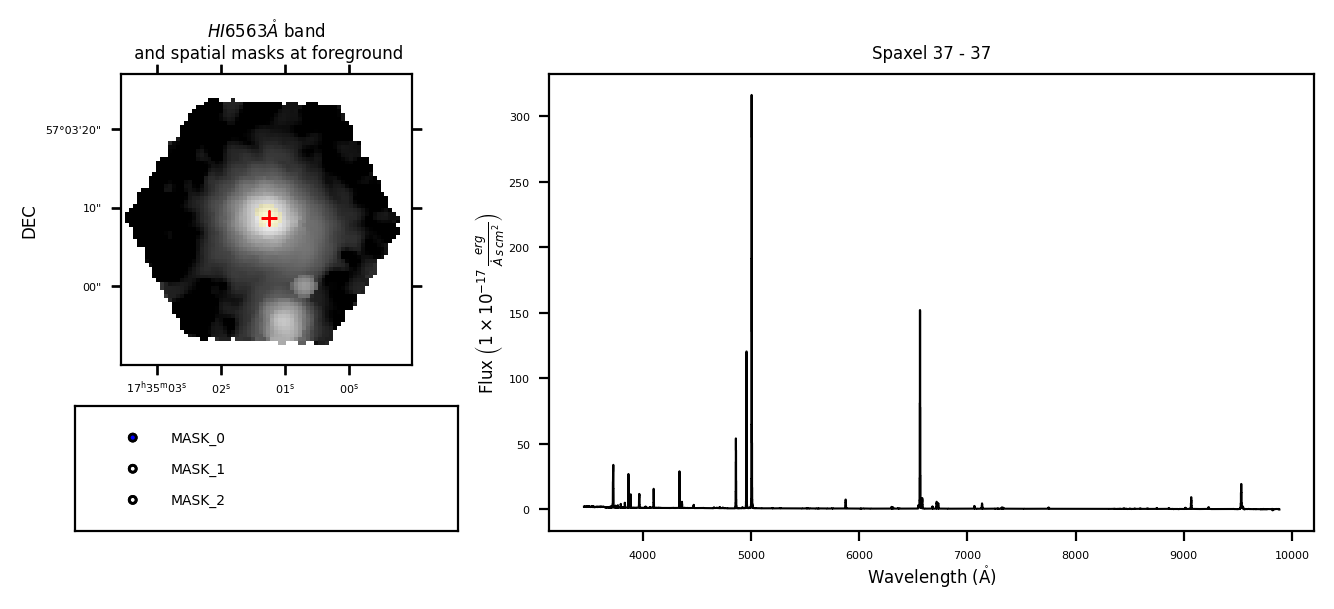

In [4]:
# Load the Cube
shoc579 = lime.Cube.from_file(cube_file, instrument='manga', redshift=z_obj)
shoc579.check.cube('H1_6563A', masks_file=spatial_mask_file, rest_frame=True)

At this point, you have diferent strategies to fit lines on this IFU observation. For example, you can recover the spectrum from a spaxel using the flux array coordinates.

<div class="alert alert-info">

**Please remember:** This is a [numpy array](https://numpy.org/devdocs/_images/np_matrix_indexing.png), the first and second indeces correspond to the vertical and horizontal axis respectively. These are the spatial axis on an IFU observation. The third index corresponds to the cube depth axis or the IFU wavelength array. The origin in this numerical array is located on the  upper-left-front corner on the 3D array.

</div>

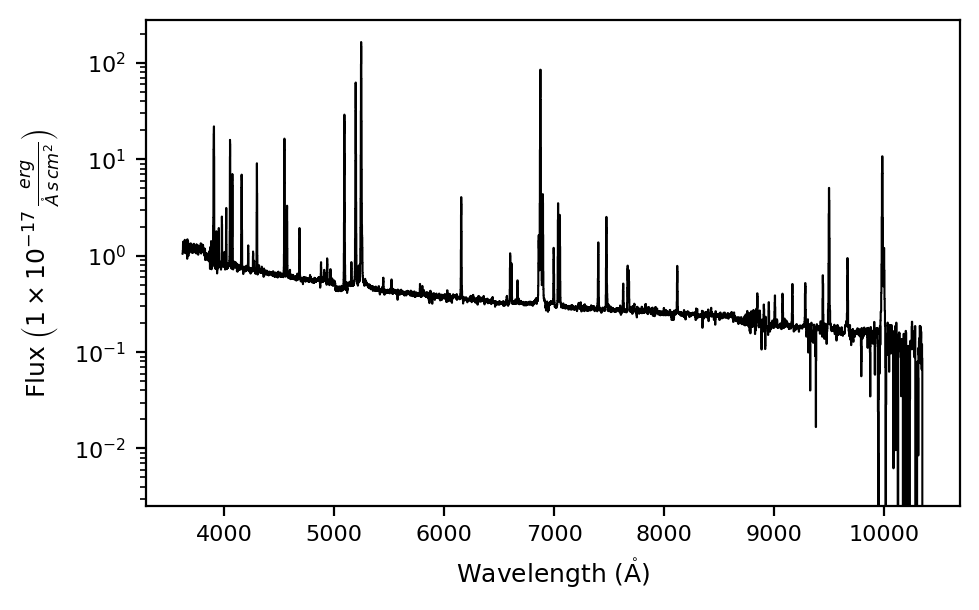

In [5]:
# Extract one spaxel (idx Y, idx X):
spaxel = shoc579.get_spectrum(38, 35)
spaxel.plot.spectrum(log_scale=True)

We can use the ``.fit.frame`` function we visisted in the [3rd tutorial](https://lime-stable.readthedocs.io/en/latest/tutorials/3_CompleteSpectrumFitting.html):

In [6]:
spaxel.fit.frame(bands_file_0, cfg_file, line_detection=True, id_conf_prefix='MASK_0')


Line fitting progress:
[==========] 100% of 39 lines (S3_9531A_b)

The fitted profiles can be displayed using the ``.plot.spectrum`` function:

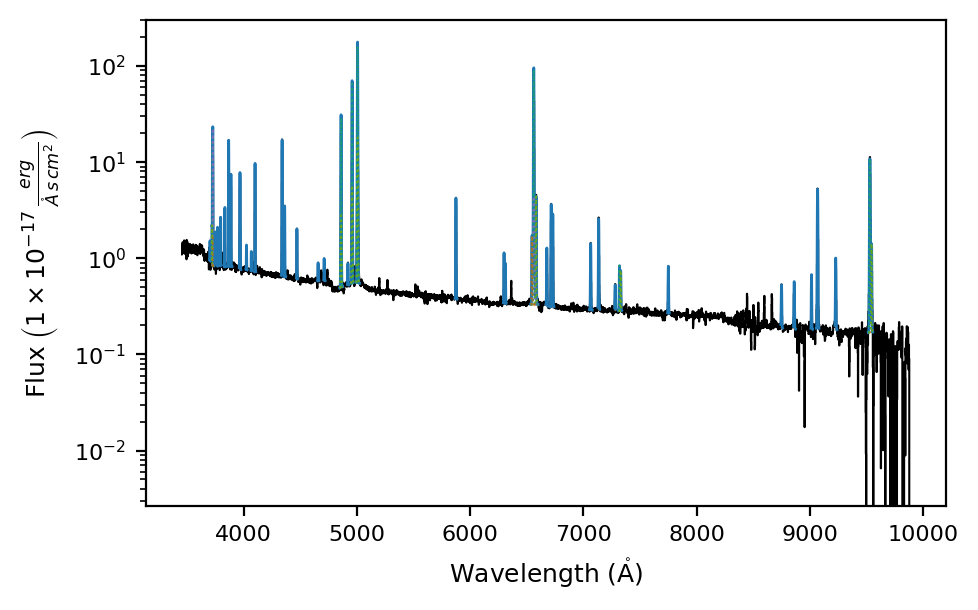

In [7]:
spaxel.plot.spectrum(include_fits=True, rest_frame=True, log_scale=True)

To recover the array coordinates from your spatial mask you can use the ``lime.load_spatial_mask``:

In [8]:
masks_dict = lime.load_spatial_mask(spatial_mask_file, return_coords=True)

By default this dictionary contains the mask array (as boolean values) and header for every extension in the input file. However, if you set the argument ``return_coords=True`` you will get the array coordinates for every ``True`` value in the spatial mask. You can use this information to analyse the spectra lines:

In [9]:
masks_dict = lime.load_spatial_mask(spatial_mask_file, return_coords=True)
for i, coords in enumerate(masks_dict['MASK_0']):
    print(f'Spaxel {i}) Coordinates {coords}')
    idx_Y, idx_X = coords
    spaxel = shoc579.get_spectrum(idx_Y, idx_Y)
    spaxel.fit.frame(bands_file_0, obs_cfg, line_list=['H1_6563A_b'], id_conf_prefix='MASK_0', plot_fit=False, progress_output=None)

Spaxel 0) Coordinates [35 35]
Spaxel 1) Coordinates [35 36]
Spaxel 2) Coordinates [35 38]
Spaxel 3) Coordinates [35 39]
Spaxel 4) Coordinates [36 35]
Spaxel 5) Coordinates [36 36]
Spaxel 6) Coordinates [36 37]
Spaxel 7) Coordinates [36 38]
Spaxel 8) Coordinates [36 39]
Spaxel 9) Coordinates [36 40]
Spaxel 10) Coordinates [37 35]
Spaxel 11) Coordinates [37 36]
Spaxel 12) Coordinates [37 37]
Spaxel 13) Coordinates [37 38]
Spaxel 14) Coordinates [37 39]
Spaxel 15) Coordinates [37 40]
Spaxel 16) Coordinates [38 34]
Spaxel 17) Coordinates [38 35]
Spaxel 18) Coordinates [38 36]
Spaxel 19) Coordinates [38 37]
Spaxel 20) Coordinates [38 38]
Spaxel 21) Coordinates [38 39]
Spaxel 22) Coordinates [38 40]
Spaxel 23) Coordinates [39 34]
Spaxel 24) Coordinates [39 35]
Spaxel 25) Coordinates [39 36]
Spaxel 26) Coordinates [39 37]
Spaxel 27) Coordinates [39 38]
Spaxel 28) Coordinates [39 39]
Spaxel 29) Coordinates [40 35]
Spaxel 30) Coordinates [40 36]
Spaxel 31) Coordinates [40 37]
Spaxel 32) Coordin

To treat serveral spaxels in an efficient workflow, you can use ``.fit.spatial_mask``. This function allows you to fit some or all the masks in the input ``spatial_mask_file``. Moreover, it will save the results into a *.fits* file specified in the ``output_log`` argument. Each page on the output *.fits* file corresponds to a spaxel.

In [10]:
# Fit the lines in all the masks spaxels
shoc579.fit.spatial_mask(spatial_mask_file, fit_conf=obs_cfg, line_detection=True, output_address=output_lines_log_file)


Spatial mask 1/3) MASK_0 (33 spaxels)
[==========] 100% of mask (spaxel coordinate. 40-38)
1633 lines measured in 0.51 minutes.

Spatial mask 2/3) MASK_1 (97 spaxels)
[==========] 100% of mask (spaxel coordinate. 43-39)
3218 lines measured in 1.02 minutes.

Spatial mask 3/3) MASK_2 (97 spaxels)
[==========] 100% of mask (spaxel coordinate. 54-26)
1340 lines measured in 0.53 minutes.

Joining spatial log files (MASK_0,MASK_1,MASK_2) -> ../sample_data/SHOC579_log.fits
[==========] 100% of log files combined 

<div class="alert alert-info">

**Please remember:** The ``.fit.spatial_mask`` function cannot add or update measurements on an existing *.fits* file. It will always overwrite an existing file on the provided ``output_log`` path.

</div>

However, the most import feature from the ``.fit.spatial_mask`` is the ability to organize the configuration of your fittings. The image below shows the spatial masks of SHOC579 alongside part of its configuration [manga.toml](https://github.com/Vital-Fernandez/lime/blob/master/examples/sample_data/manga.toml) file:

<img src="../images/mask_conf_diagram.png" alt="SHOC579 MANGA field" title="SHOC579"/>


In these measurements the ``.fit.spatial_mask`` can recognize up to three configuration levels:

* At the lowest level, the *[default_line_fitting]* section provides a fitting configuration all spaxels, independtly of the mask. The name of this section can be modified with the ``default_conf_prefix="default"`` 
* The *[MASK_0_line_fitting]*, *[MASK_1_line_fitting]* and *[MASK_2_line_fitting]* sections provide the fitting configuration for each mask. These entries **update** the information from the *[default_line_fitting]*. This means that:
    * In all the masked spaxels *H1_3889A_m=H1_3889A+He1_3889A* and *Ar4_4711A_m = Ar4_4711A-He1_4713A*.
    * In *[MASK_0_line_fitting]* the line ``O2_3726A_b`` has four components while in *[MASK_1_line_fitting]* it only has two
    * Since *[MASK_2_line_fitting]* does not have any items, the fitting configuration is the same as in *[default_line_fitting]*.
* At the highest level the *[38-35_line_fitting]* section updates the fitting properties of the spaxel on red. Consequently, just in that spaxel *O3_5007A_b = O3_5007A+O3_5007A_k-1+He1_5016A*. Again this entry **updates** the information from the *[MASK_0_line_fitting]* and the *[default_line_fitting]* sections.

We can confirm this configuration by checking this spaxel, the only one with the fitting of the $HeI5016Å$ line: 

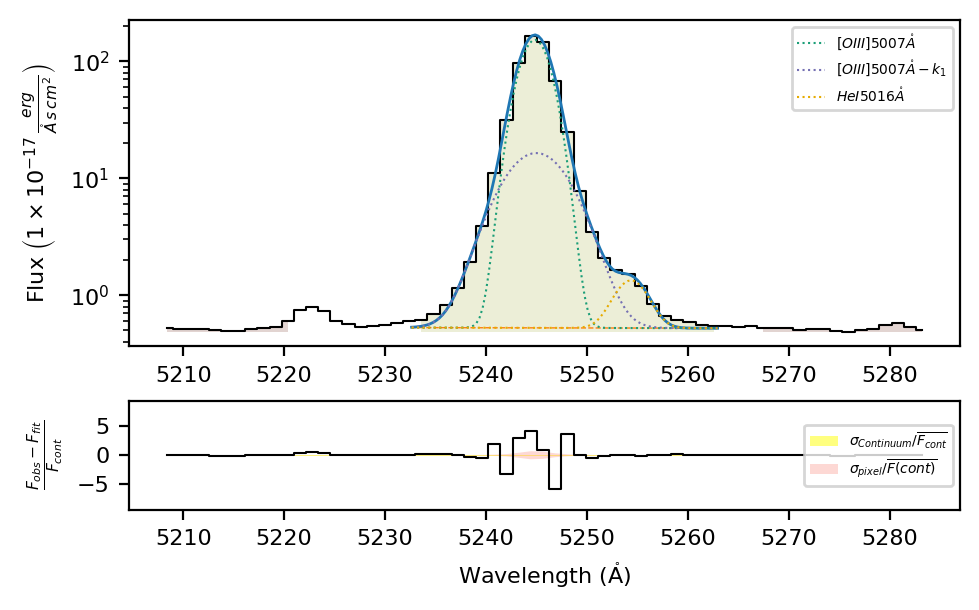

In [12]:
# Check the individual spaxel fitting configuration
spaxel = shoc579.get_spectrum(38, 35)
spaxel.load_frame(output_lines_log_file, page='38-35_LINELOG')
spaxel.plot.bands('He1_5016A')

Additionally, you can adjust the ``.fit.spatial_mask`` measurements with these arguments:

* In the ``mask_name_list=`` you can specify the masks to use from the ``spatial_mask_file`` (the default is all of them).
* This function can only save the measurements as a *.fits* file. This file is specified using the ``output_log=output_lines_log_file``. Each page on the *.fits* file corresponds to a spaxel. The default page name is **idxY-idxX_LINELOG**. You can change the default extension suffix with the ``log_ext_suffix='_LINELOG'`` argument.
* By default the ``.fit.spatial_mask`` saves the results as a *.fits* for each mask. Afterwards, the files are joined together and the individual spatial mask measurements files are deleted. This operation may take some time depending on the size of the *.fits* files. you can keep the individual files by setting the argument ``join_output_files=True``. Afterwards, you can join the individual files using the [``combine_fits_files``](https://lime-stable.readthedocs.io/en/latest/introduction/api.html#lime.tools.logs_into_fits) function

Finally, you can visualize the fitted profiles on the output *.fits* using the ``.plot.cube`` function:

/home/vital/PycharmProjects/lime/.venv/new_interpr/lib/python3.10/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


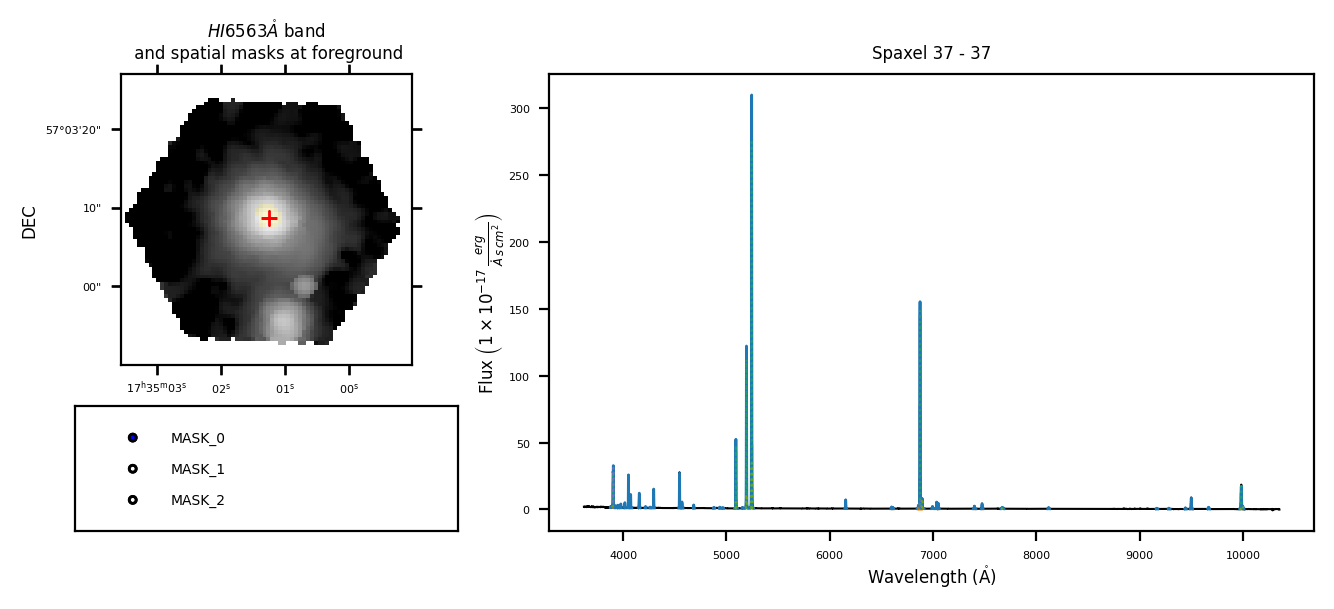

In [13]:
# Review the fittings
shoc579.check.cube('H1_6563A', lines_file=output_lines_log_file, masks_file=spatial_mask_file)